<a href="https://colab.research.google.com/github/GabrielCdev/titanic_disaster_analysis/blob/main/Titanic_with_IA_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Atividade 02

Base para a atividade: https://www.kaggle.com/competitions/titanic/data

###....:::: Membros ::::....

Áureo Ramos

Gabriel Borges Calheiros

Izadora de Oliveira Machado Paim

Laianne Protásio

In [1]:
# bibliotecas principais
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from numpy.random import RandomState

In [2]:
# Carga dos dados .csv
titanic_df = pd.read_csv('https://raw.githubusercontent.com/GabrielCdev/titanic_disaster_analysis/main/titanic/train.csv')

In [3]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C


In [4]:
#Separando o dataset em treino e teste
# seed = 1
# rng = RandomState(seed)

# train_df = titanic_df.sample(frac=0.8, random_state=rng)
# test_df = titanic_df.loc[~titanic_df.index.isin(train_df.index)]

In [5]:
train_df = titanic_df
test_df = titanic_df

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Funções de Pré-processamento das bases

In [7]:
def preprocessing(dataset: pd.DataFrame, mean_ages: pd.Series = pd.Series()):
  # Alterando o tipo de dados do dataset
  dataset['Name'] = dataset['Name'].astype('string')
  dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)
  dataset['Cabin'] = dataset['Cabin'].astype('category')
  dataset['Embarked'] = dataset['Embarked'].astype('category')
  
  # Criando uma nova coluna para Pronomes de Tratamento
  dataset['Treatment pronouns'] = dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

  # Criando uma nova coluna para verificar os passageiros que tinham parentes à bordo
  dataset.insert(len(dataset.columns),'Relatives',np.nan)
  dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
  dataset['Relatives'] = dataset.Relatives.apply(lambda x: 0 if x == 0 else 1)

  # Removendo colunas do dataset
  dataset.drop(columns='PassengerId', inplace=True)
  dataset.drop(columns='Ticket', inplace=True)
  dataset.drop(columns='Name', inplace=True)
  dataset.drop(columns='SibSp', inplace=True)
  dataset.drop(columns='Parch', inplace=True)
  dataset.drop(columns='Cabin', inplace=True)
  dataset.drop(columns='Embarked', inplace=True)
  
  if (mean_ages.empty):
    output, mean_ages = completeNullAge_train(dataset)
  else:
    output = completeNullAge_test(dataset, mean_ages)

  # Agrupando idades em classes
  classes = [0, 5, 10, 18, 29, 100]
  labels = ['Baby', 'Children', 'Young', 'Adults', 'Aged']
  classes = pd.cut(x=dataset.Age, bins=classes, labels=labels)
  dataset['Age'] = classes

  # Mapeando os Pronomes de Tratamento
  dataset['Treatment pronouns'] = dataset['Treatment pronouns'].map({'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Others': 4}).astype(int)

  # Mapeando as Idades
  dataset['Age'] = dataset['Age'].map({'Baby': 0, 'Children': 1, 'Young': 2, 'Adults': 3, 'Aged': 4}).astype(int)

  # Mapeando o preço dos tickets
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  return output, mean_ages

<ipython-input-7-6cdfad877750>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def preprocessing(dataset: pd.DataFrame, mean_ages: pd.Series = pd.Series()):


In [8]:
#Completando as idades faltantes/NaN a partir da média das idades com base em Pclass e Treatment pronouns
def completeNullAge_train(dataset: pd.DataFrame):
  #Substituindo os Treatment Pronouns menos frequentes por Others
  threshold = dataset['Treatment pronouns'].value_counts()[3]
  dataset.loc[dataset['Treatment pronouns'].value_counts()[dataset['Treatment pronouns']].values < threshold, 'Treatment pronouns'] = 'Others'
  for i in range(len(dataset['Age'])):
    pclass = dataset['Pclass'].iloc[i]
    tp = dataset['Treatment pronouns'].iloc[i]
    dataset_mean_age = dataset.groupby(['Treatment pronouns','Pclass'])['Age'].mean()
    
    if pd.isnull(dataset['Age'].iloc[i]):
      dataset['Age'].iloc[i] = dataset_mean_age[tp,pclass]
  
  return dataset, dataset_mean_age

In [9]:
#Completando as idades faltantes/NaN a partir da média das idades com base em Pclass e Treatment pronouns
def completeNullAge_test(dataset: pd.DataFrame, dataset_mean_age):
  #Substituindo os Treatment Pronouns menos frequentes por Others
  allowed_vals = []
  temp = set()
  for inner in dataset_mean_age.index:
    for elem in inner:
      if (not elem in temp) & (isinstance(elem, str)):
        temp.add(elem)
        allowed_vals.append(elem)
  
  dataset.loc[~dataset['Treatment pronouns'].isin(allowed_vals), 'Treatment pronouns'] = 'Others'

  for i in range(len(dataset['Age'])):
    if pd.isnull(dataset['Age'].iloc[i]) & ~pd.isnull(dataset['Pclass'].iloc[i]) & ~pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      pclass = dataset['Pclass'].iloc[i]
      tp = dataset['Treatment pronouns'].iloc[i]
      dataset['Age'].iloc[i] = mean_ages[tp,pclass]
    elif pd.isnull(dataset['Age'].iloc[i]) & ~pd.isnull(dataset['Pclass'].iloc[i]) & pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      print('none1') #não foi desenvolvido porque essa hipótese não ocorre no dataset, mas poderia ocorrer numa situação real
    elif pd.isnull(dataset['Age'].iloc[i]) & pd.isnull(dataset['Pclass'].iloc[i]) & ~pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      print('none2') #não foi desenvolvido porque essa hipótese não ocorre no dataset, mas poderia ocorrer numa situação real
    elif pd.isnull(dataset['Age'].iloc[i]) & pd.isnull(dataset['Pclass'].iloc[i]) & pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      print('none3') #não foi desenvolvido porque essa hipótese não ocorre no dataset, mas poderia ocorrer numa situação real

  return dataset

##Aplicando o pré-processamento

In [10]:
mean_ages = preprocessing(train_df)[1]

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Treatment pronouns,Relatives
0,0,3,0,3,0,0,1
1,1,1,1,4,3,1,1
2,1,3,1,3,1,2,0
3,1,1,1,4,3,1,1
4,0,3,0,4,1,0,0


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Survived            891 non-null    int64
 1   Pclass              891 non-null    int64
 2   Sex                 891 non-null    int64
 3   Age                 891 non-null    int64
 4   Fare                891 non-null    int64
 5   Treatment pronouns  891 non-null    int64
 6   Relatives           891 non-null    int64
dtypes: int64(7)
memory usage: 48.9 KB


In [13]:
test_df

,Survived,Pclass,Sex,Age,Fare,Treatment pronouns,Relatives
0,0,3,0,3,0,0,1
1,1,1,1,4,3,1,1
2,1,3,1,3,1,2,0
3,1,1,1,4,3,1,1
4,0,3,0,4,1,0,0
...,...,...,...,...,...,...,...
886,0,2,0,3,1,4,0
887,1,1,1,3,2,2,0
888,0,3,1,2,2,2,1
889,1,1,0,3,2,0,0


##Aplicando os classificadores

In [14]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

###Cross-Validation

In [15]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(test_df))
depth_range = (1, max_attributes + 1)

In [16]:
for depth in depth_range:
  fold_accuracy = []
  tree_model = tree.DecisionTreeClassifier(max_depth = depth)
  
  for train_fold, valid_fold in cv.split(train_df):
    f_train = train_df.loc[train_fold]
    f_valid = train_df.loc[valid_fold]

    model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                            y = f_train["Survived"])
    valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                            y = f_valid["Survived"])
    fold_accuracy.append(valid_acc)

fold_accuracy

[0.7666666666666667,
 0.8426966292134831,
 0.7528089887640449,
 0.8202247191011236,
 0.8764044943820225,
 0.7865168539325843,
 0.797752808988764,
 0.7865168539325843,
 0.8651685393258427,
 0.8089887640449438]

###Árvore de Decisão

In [17]:
X_dt = train_df.iloc[:, 1:]
Y_dt = train_df.iloc[:, 0]
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, Y_dt, test_size=0.3, random_state=60)

In [18]:
y_train_dt = train_df['Survived']
X_train_dt = train_df.drop(['Survived'], axis=1).values 
X_test_dt = test_df.values

In [19]:
decision_tree = DecisionTreeClassifier(max_depth = 5)
decision_tree.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(max_depth=5)

In [20]:
acc_decision_tree = round(decision_tree.score(X_train_dt, y_train_dt) * 100, 2)
acc_decision_tree

83.39

###Random Forest

In [21]:
X_rf = train_df.iloc[:, 1:]
y_rf = train_df['Survived']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, stratify=y_rf, test_size=0.3, random_state=100)

forest = RandomForestClassifier(n_estimators=100, random_state=100)

forest.fit(X_train_rf, y_train_rf)
forest.predict(X_test_rf)
forest

RandomForestClassifier(random_state=100)

In [22]:
acc_random_forest = round(forest.score(X_train_rf, y_train_rf) * 100, 2)
acc_random_forest

85.23

###kNN

In [23]:
X_knn = train_df.iloc[:, 1:5].values
Y_knn = train_df.iloc[:, 0].values

In [24]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, Y_knn, test_size=0.3, random_state=3)

In [25]:
k_range = range(1, 26)
scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train_knn, y_train_knn)
  y_pred = knn.predict(X_test_knn)
  scores.append(metrics.accuracy_score(y_test_knn, y_pred))

scores

[0.8097014925373134,
 0.7985074626865671,
 0.8059701492537313,
 0.7873134328358209,
 0.7985074626865671,
 0.7985074626865671,
 0.7947761194029851,
 0.7947761194029851,
 0.7649253731343284,
 0.75,
 0.7835820895522388,
 0.7873134328358209,
 0.7798507462686567,
 0.7910447761194029,
 0.7761194029850746,
 0.7798507462686567,
 0.7835820895522388,
 0.7723880597014925,
 0.7835820895522388,
 0.7947761194029851,
 0.7761194029850746,
 0.7761194029850746,
 0.7947761194029851,
 0.7873134328358209,
 0.7947761194029851]

In [26]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_knn, y_train_knn)
y_pred = knn.predict(X_test_knn)

acc_knn = metrics.accuracy_score(y_test_knn, y_pred)
acc_knn

0.8097014925373134

###Matriz de Confusão

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

In [28]:
def model_evaluation(classifier, y_test=None, x_test=None):
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    tn,fp,fn,tp = cm.flatten()
    
    print('PRECISION : ','{0:.2%}'.format(tp/(tp + fp)))
    print('RECALL : ','{0:.2%}'.format(tp/(tp + fn)))

In [29]:
y_test_dt.shape

(268,)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


PRECISION :  90.12%
RECALL :  65.77%


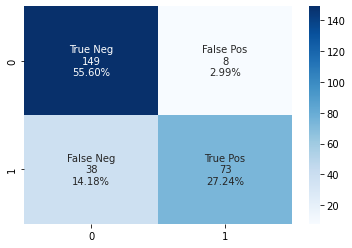

In [30]:
# Decision Tree
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, Y_dt, test_size=0.3, random_state=60)
model_evaluation(decision_tree, y_test_dt, X_test_dt)

In [31]:
predictions_dt = cross_val_predict(decision_tree, X_train_dt, y_train_dt, cv=3)

In [32]:
f1_score(y_train_dt, predictions_dt)

0.7044917257683214

PRECISION :  80.22%
RECALL :  70.87%


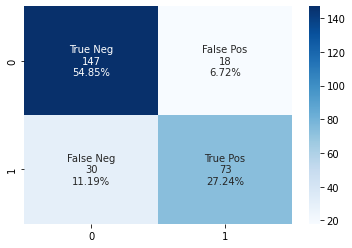

In [33]:
# Random Forest
model_evaluation(forest, y_test_rf, X_test_rf)

In [34]:
predictions_rf = cross_val_predict(forest, X_train_rf, y_train_rf, cv=3)

In [35]:
f1_score(y_train_rf, predictions_rf)

0.6958525345622121

PRECISION :  74.31%
RECALL :  77.88%


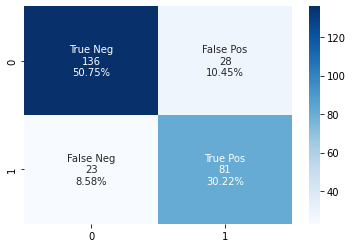

In [36]:
# kNN
model_evaluation(knn, y_test_knn, X_test_knn)

In [37]:
predictions_knn = cross_val_predict(knn, X_train_knn, y_train_knn, cv=3)

In [38]:
f1_score(y_train_knn, predictions_knn)

0.6791666666666667

# Dataset de Teste

In [39]:
# titanic_test_df = pd.read_csv('https://raw.githubusercontent.com/GabrielCdev/titanic_disaster_analysis/main/titanic/test.csv')

In [40]:
# preprocessing(titanic_test_df, mean_ages)[0]

In [41]:
# titanic_test = titanic_test_df.iloc[:, 1:5].values

In [42]:
# submission = pd.DataFrame({
#   "PassengerId": titanic_test_df["PassengerId"],
#   "Survived": forest.predict(titanic_test)
# })

# submission.to_csv('submission.csv', index=False)
# files.download('submission.csv')

# Comentários

- Após o uso da matriz de confusão, viu-se um recall maior que 56%, o que mostra que o modelo foi capaz de identificar muitos exemplos positivos. Sendo o maior Recall vindo do algoritmo kNN.

- A precisão do modelo manteve-se maior que 75%, sendo a maior vista no uso do algoritmo de Árvore de Decisão.

- Árvore de Decisão:
 - 150 passageiros foram classificados corretamente como não sobreviventes e 14 foram classificados de forma errada como não sobreviventes.
  - 36 passageiros classificados de forma errada como sobreviventes e 68 corretamente classificados como sobreviventes.
  - A precisão do modelo prevê a sobrevivência de passageiros de forma correta em quase 83% das vezes.
  - O Recall comprova a assertividade dos que sobreviveram em 65% das vezes.
  - F1 Score foi de aproximadamente 72%.

- Random Forest:
 - 147 passageiros foram classificados corretamente como não sobreviventes e 18 foram classificados de forma errada como não sobreviventes.
  - 30 passageiros classificados de forma errada como sobreviventes e 73 corretamente classificados como sobreviventes.
  - A precisão do modelo prevê a sobrevivência de passageiros de forma correta em 80% das vezes.
  - O Recall comprova a assertividade dos que sobreviveram com quase 71%.
  - F1 Score foi de aproximadamente 70%.

- kNN:
  - 136 passageiros foram classificados corretamente como não sobreviventes e 28 foram classificados de forma errada como não sobreviventes.
  - 23 passageiros classificados de forma errada como sobreviventes e 81 corretamente classificados como sobreviventes.
  - A precisão do modelo prevê a sobrevivência de passageiros de forma correta em 74% das vezes.
  - O Recall comprova a assertividade dos que sobreviveram com quase 78%.
  - F1 Score foi de aproximadamente 68%.